# Running on DBLP data set

#### Downloading dataset [Optional]

In [ ]:
# %%shell
# curl -O https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0  25.8M      0  0:00:04  0:00:04 --:--:-- 26.4M


In [ ]:
# %%shell
# yes | unzip -o citation-network1.zip

Archive:  citation-network1.zip
  inflating: outputacm.txt           


#### Print first N lines from dataset (outputacm.txt)

In [ ]:
N = 10
with open('Data/outputacm.txt', 'r') as file:
    for i, line in enumerate(file):
        if i >= N:
            break
        print(line.strip())


629814
#*Automated Deduction in Geometry: 5th International Workshop, ADG 2004, Gainesville, FL, USA, September 16-18, 2004, Revised Papers (Lecture Notes in Computer ... / Lecture Notes in Artificial Intelligence)
#@Hoon Hong,Dongming Wang
#t2006
#c
#index0

#*A+ Certification Core Hardware (Text & Lab Manual)
#@Charles J. Brooks
#t2003


The above file contains Topic of paper which starts with '#*' and authors starts with '#@'.

## Importing modules

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from collections import defaultdict, Counter
import networkx as nx
import pandas as pd
import numpy as np
import re

from multiprocessing import Pool  # For parallel processing

## Building a Co-authorship network

In [ ]:
# Function to build the co-authorship network based on input txt file
def build_coauthorship_network(filename):
    G = nx.Graph()
    author_paper_count = defaultdict(int)  # For productivity score (PROD)
    coauthorship_strength = defaultdict(lambda: defaultdict(int))  # Track collaboration count

    with open(filename, 'r', encoding='utf-8') as file:
        authors = []
        for line in file:
            if line.startswith('#@'):
                authors = line[2:].strip().split(',')
                authors = [author.strip() for author in authors]

                for author in authors:
                    author_paper_count[author] += 1

                for i in range(len(authors)):
                    for j in range(i + 1, len(authors)):
                        G.add_edge(authors[i], authors[j])
                        coauthorship_strength[authors[i]][authors[j]] += 1
                        coauthorship_strength[authors[j]][authors[i]] += 1

    return G, author_paper_count, coauthorship_strength

filename = 'Data/outputacm.txt'
coauthorship_network, author_paper_count, coauthorship_strength = build_coauthorship_network(filename)

## Doings basic analysis

In [6]:
print(f"Number of nodes (authors): {coauthorship_network.number_of_nodes()}")
print(f"Number of edges (co-authorships): {coauthorship_network.number_of_edges()}")

Number of nodes (authors): 504996
Number of edges (co-authorships): 1137165


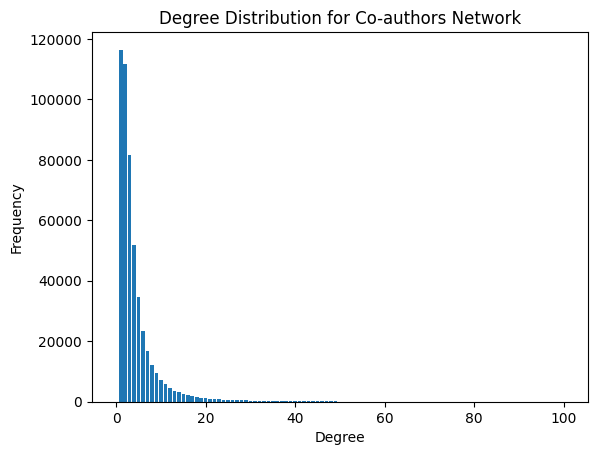

In [7]:
# Plotting Degree distribution-
degree_sequence = sorted([d for n, d in coauthorship_network.degree()], reverse=True)
degree_count = nx.degree_histogram(coauthorship_network)

max_degree = 100
degree_count_restricted = degree_count[:max_degree + 1]

degree_values_restricted = range(min(len(degree_count_restricted), max_degree + 1))

plt.bar(degree_values_restricted, degree_count_restricted)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution for Co-authors Network")
plt.show()

Based on this we can see it follows power law.

## Running three elections on the network, each producing scorings based of a method.

### Election A (*productivity only*): x votes for the most prolific among her co-authors; ties are broken using strength of co-authorship.

In [8]:
# Election A: Vote based on productivity
def election_a(G, author_paper_count):
    votes = {}
    for author in G.nodes():
        coauthors = list(G.neighbors(author))
        if coauthors:
            # Select the co-author with the highest productivity
            best_coauthor = max(coauthors, key=lambda x: (author_paper_count[x], coauthorship_strength[author][x]))
            votes[author] = best_coauthor
        else:
            votes[author] = author  # Self-vote if no co-authors
    return votes

### Election B (*strength of co-authorship only*): x votes for her main co-author (the one with which x wrote most papers) ties are broken using productivity.

In [9]:
# Election B: Vote based on co-authorship strength
def election_b(G, author_paper_count):
    votes = {}
    for author in G.nodes():
        coauthors = list(G.neighbors(author))
        if coauthors:
            # Select the co-author with the strongest collaboration
            best_coauthor = max(coauthors, key=lambda x: (coauthorship_strength[author][x], author_paper_count[x]))
            votes[author] = best_coauthor
        else:
            votes[author] = author  # Self-vote if no co-authors
    return votes

### Election C (*adjusted co-authorship*): x considers her co-authors in decreasing order of strength of co-authorship, and votes for the first one that has been more productive than x (i.e., that has written more papers than x); if no such co-author exists, x votes for herself.

In [10]:
# Election C: Adjusted co-authorship voting
def election_c(G, author_paper_count):
    votes = {}
    for author in G.nodes():
        coauthors = list(G.neighbors(author))
        # Sort co-authors by collaboration strength in descending order
        coauthors.sort(key=lambda x: coauthorship_strength[author][x], reverse=True)
        voted = False
        for coauthor in coauthors:
            if author_paper_count[coauthor] > author_paper_count[author]:
                votes[author] = coauthor
                voted = True
                break
        if not voted:
            votes[author] = author  # Self-vote if no suitable co-author is found
    return votes

In [11]:
# Run the elections
votes_a = election_a(coauthorship_network, author_paper_count)
votes_b = election_b(coauthorship_network, author_paper_count)
votes_c = election_c(coauthorship_network, author_paper_count)

# Count results
def count_votes(votes):
    return Counter(votes.values())

In [12]:
count_votes(votes_a).most_common(5)

[('Jr.', 6363),
 ('III', 1231),
 ('II', 693),
 ('Wei Wang', 291),
 ('Ming Li', 228)]

In [13]:
count_votes(votes_b).most_common(5)

[('Jr.', 5045), ('III', 952), ('II', 526), ('Wei Wang', 153), ('Ming Li', 124)]

In [14]:
count_votes(votes_c).most_common(5)

[('Jr.', 3123),
 ('III', 644),
 ('II', 267),
 ('S Chatterjee', 111),
 ('Wei Li', 86)]

## Calculating other four static scoring-

In [15]:
# Calculate Degree Centrality (DEG)
degree_centrality = nx.degree_centrality(coauthorship_network)

# Calculate PageRank (PR)
pagerank_scores = nx.pagerank(coauthorship_network, alpha=0.85)

# Calculate Productivity (PROD)
# The productivity score is already calculated in author_paper_count

# Calculate Voting Centrality (CEN)
voting_centrality = nx.pagerank(coauthorship_network, alpha=0.85, personalization=degree_centrality)

## Finding Kendall's Tau correlation coefficient for 7 scorings-

In [16]:
# Using dictionaries for rankings
def compute_ranking(scores_dict, authors_list):
    rank_dict = {author: rank for rank, author in enumerate(
        sorted(scores_dict, key=scores_dict.get, reverse=True))}
    return np.array([rank_dict.get(author, len(authors_list)) for author in authors_list])

# List of all unique authors
all_authors = list(set(degree_centrality.keys()) | set(author_paper_count.keys()))

# Generate ranking arrays for each metric
degree_rank = compute_ranking(degree_centrality, all_authors)
pagerank_rank = compute_ranking(pagerank_scores, all_authors)
productivity_rank = compute_ranking(author_paper_count, all_authors)
voting_rank = compute_ranking(voting_centrality, all_authors)
election_a_rank = compute_ranking(votes_a, all_authors)
election_b_rank = compute_ranking(votes_b, all_authors)
election_c_rank = compute_ranking(votes_c, all_authors)

In [17]:
# Compute Kendall's Tau correlations
def kendall_tau_correlation(rank1, rank2):
    tau, _ = kendalltau(rank1, rank2)
    return tau


# Calculate Kendall's Tau for each pair
ranks = [degree_rank, pagerank_rank, productivity_rank, voting_rank, election_a_rank, election_b_rank, election_c_rank]
rank_names = ['DEG', 'PR', 'PROD', 'CEN', 'ELECTION A', 'ELECTION B', 'ELECTION C']

# DataFrame to hold the Kendall's Tau correlations
kendall_corr = pd.DataFrame(1.0, columns=rank_names, index=rank_names)  # Start with 1's on the diagonal

# Filling the DataFrame with Kendall's Tau correlations
for i in range(len(ranks)):
    for j in range(len(ranks)):
        if i == j:
            continue
        tau = np.round(kendall_tau_correlation(ranks[i], ranks[j]), 4)
        kendall_corr.at[rank_names[i], rank_names[j]] = tau
        kendall_corr.at[rank_names[j], rank_names[i]] = tau  # For symmetry

In [18]:
# Show the resulting table
print("Kendall's Tau Correlation Table:\n------------------------------------------")

kendall_corr

Kendall's Tau Correlation Table:
------------------------------------------


,DEG,PR,PROD,CEN,ELECTION A,ELECTION B,ELECTION C
DEG,1.0000,0.5128,0.3591,0.7196,0.2699,0.2690,0.2689
PR,0.5128,1.0000,0.3126,0.7087,0.2606,0.2600,0.2594
PROD,0.3591,0.3126,1.0000,0.3035,0.0720,0.0710,0.0709
CEN,0.7196,0.7087,0.3035,1.0000,0.2611,0.2603,0.2603
ELECTION A,0.2699,0.2606,0.0720,0.2611,1.0000,0.9144,0.5901
ELECTION B,0.2690,0.2600,0.0710,0.2603,0.9144,1.0000,0.6062
ELECTION C,0.2689,0.2594,0.0709,0.2603,0.5901,0.6062,1.0000


# Simulating on Random Networks

In [19]:
# Parameters
num_nodes = 504996
num_edges = 1137165

# Calculate probability p
p = (2 * num_edges) / (num_nodes * (num_nodes - 1))

# Generate an Erdős-Rényi graph
random_network = nx.fast_gnp_random_graph(num_nodes, p, seed=42)

# Simulate productivity scores (PROD) and co-authorship strength
author_paper_count = {node: np.random.randint(1, 3500) for node in random_network.nodes()}  # Random productivity
coauthorship_strength = defaultdict(lambda: defaultdict(int))

# Randomly assign weights to edges to simulate co-authorship strength
for u, v in random_network.edges():
    weight = np.random.randint(1, 150)
    random_network[u][v]['weight'] = weight
    coauthorship_strength[u][v] = weight
    coauthorship_strength[v][u] = weight

### Running all three elections here

In [20]:
# Run the elections
votes_a_random = election_a(random_network, author_paper_count)
votes_b_random = election_b(random_network, author_paper_count)
votes_c_random = election_c(random_network, author_paper_count)

In [21]:
count_votes(votes_a_random).most_common(5)

[(172943, 15), (11934, 15), (171985, 14), (263915, 14), (135737, 14)]

In [22]:
count_votes(votes_b_random).most_common(5)

[(492610, 8), (430298, 8), (45128, 7), (444075, 7), (391225, 7)]

In [23]:
count_votes(votes_c_random).most_common(5)

[(171985, 13), (443314, 11), (214863, 11), (367733, 10), (430298, 10)]

### Calculating other four static scores

In [24]:
# Calculate static metrics
# Degree (DEG)
degree_centrality = nx.degree_centrality(random_network)

# PageRank (PR)
pagerank_scores = nx.pagerank(random_network, alpha=0.85)

# Productivity (PROD)
# Already done as author_paper_count
prod_rank = {node: author_paper_count[node] for node in random_network.nodes()}

# Voting Centrality (CEN)
voting_centrality = nx.pagerank(random_network, alpha=0.85, personalization=degree_centrality)

In [25]:
def compute_ranking(scores_dict, nodes_list):
    rank_dict = {node: rank for rank, node in enumerate(sorted(scores_dict, key=scores_dict.get, reverse=True))}
    return np.array([rank_dict.get(node, len(nodes_list)) for node in nodes_list])

# List of all unique authors
all_nodes = list(random_network.nodes())

# Generate ranking arrays for each metric
degree_rank = compute_ranking(degree_centrality, all_nodes)
pagerank_rank = compute_ranking(pagerank_scores, all_nodes)
voting_rank = compute_ranking(voting_centrality, all_nodes)
election_a_rank = compute_ranking(votes_a, all_nodes)
election_b_rank = compute_ranking(votes_b, all_nodes)
election_c_rank = compute_ranking(votes_c, all_nodes)
prod_rank_array = compute_ranking(prod_rank, all_nodes)

In [26]:
# Rankings
rankings = [
    degree_rank, pagerank_rank, voting_rank, prod_rank_array,
    election_a_rank, election_b_rank, election_c_rank
]

rank_names = ['DEG', 'PR', 'CEN', 'PROD', 'ELECTION A', 'ELECTION B', 'ELECTION C']

# Calculate Kendall's Tau for all pairs of rankings
kendall_tau_results = pd.DataFrame(np.ones((7, 7)), columns=rank_names, index=rank_names)

for i, rank1 in enumerate(rankings):
    for j, rank2 in enumerate(rankings):
        if i != j:
            tau, _ = kendalltau(rank1, rank2)
            kendall_tau_results.iloc[i, j] = round(tau, 4)

In [27]:
# Show the resulting table
print("Kendall's Tau Correlation Table for Random Network:\n------------------------------------------")

kendall_tau_results

Kendall's Tau Correlation Table for Random Network:
------------------------------------------


,DEG,PR,CEN,PROD,ELECTION A,ELECTION B,ELECTION C
DEG,1.0000,0.5906,0.6393,-0.0000,NaN,NaN,NaN
PR,0.5906,1.0000,0.9512,0.0005,NaN,NaN,NaN
CEN,0.6393,0.9512,1.0000,0.0005,NaN,NaN,NaN
PROD,-0.0000,0.0005,0.0005,1.0000,NaN,NaN,NaN
ELECTION A,NaN,NaN,NaN,NaN,1.0,NaN,NaN
ELECTION B,NaN,NaN,NaN,NaN,NaN,1.0,NaN
ELECTION C,NaN,NaN,NaN,NaN,NaN,NaN,1.0
